# Setup

In [1]:
# Generic
import copy
import typing
from pathlib import Path
import html

# Plotting
import matplotlib.pyplot as plt

# Numerical Computing
import numpy as np
import torch
# Utilities
from muutils.statcounter import StatCounter

# Our Code
from muutils.nbutils.configure_notebook import configure_notebook
from maze_dataset.plotting import MazePlot
from maze_dataset import MazeDataset, MazeDatasetConfig
from maze_transformer.training.config import ZanjHookedTransformer
from maze_transformer.evaluation.eval_model import predict_maze_paths, evaluate_model
from maze_transformer.evaluation.baseline_models import RandomBaseline
from muutils.mlutils import get_checkpoint_paths_for_run

In [2]:
# Setup
DEVICE = configure_notebook(seed=42, dark_mode=True)
PATH_EXAMPLES: Path = Path("../examples/")
PATH_DATA: Path = Path("../data/")

# We won't be training any models
torch.set_grad_enabled(False)

# get the default model from examples
MODEL_PATH: Path = PATH_EXAMPLES / "multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/model.final.zanj"
# MODEL_PATH: Path = PATH_DATA / "custom_2023-05-24-05-03-04/model.final.zanj"
print(f"will try to get model from {MODEL_PATH.as_posix()}")
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read(MODEL_PATH)
print(f"loaded model: {MODEL.zanj_model_config.name} with {MODEL.num_params()} parameters")

# generate a smaller test dataset from the same config
DATASET_TEST_CFG: MazeDatasetConfig = copy.deepcopy(MODEL.zanj_model_config.dataset_cfg)
DATASET_TEST_CFG.n_mazes = 100
DATASET_TEST: MazeDataset = MazeDataset.from_config(
    DATASET_TEST_CFG,
    local_base_path=PATH_DATA,
    verbose=True,
)
print(f"got test dataset: {DATASET_TEST.cfg.name} with {len(DATASET_TEST)} mazes")

will try to get model from ../examples/multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/model.final.zanj
loaded model: multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1 with 70319 parameters
seeing if we can download the dataset...
no download found, or download failed
generating dataset...


generating & solving mazes: 100%|██████████| 100/100 [00:00<00:00, 194.57maze/s]


saving dataset to ..\data\demo-g6-n100-a_dfs-h34285.zanj
Got dataset demo with 100 items. output.cfg.to_fname() = 'demo-g6-n100-a_dfs-h34285'
got test dataset: demo with 100 mazes


# plot example mazes

In [3]:
def testdata_plot_predicted_path(
		model: ZanjHookedTransformer,
		dataset: MazeDataset,
		n_mazes: int|None = None,
		max_new_tokens: int = 8,
	):
	if n_mazes is None:
		n_mazes = len(dataset)

	# predict
	predictions: list[list[tuple[int,int]]] = predict_maze_paths(
		tokens_batch=dataset.as_tokens()[:n_mazes],
		data_cfg=dataset.cfg,
		model=model,
		max_new_tokens=max_new_tokens,
	)

	# plot
	for i, maze in enumerate(dataset.mazes[:n_mazes]):
		MazePlot(maze).add_predicted_path(predictions[i]).plot()
		plt.show()


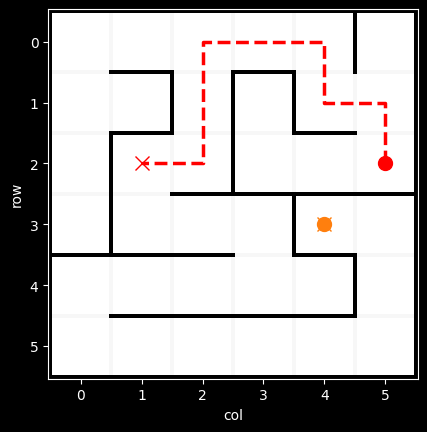

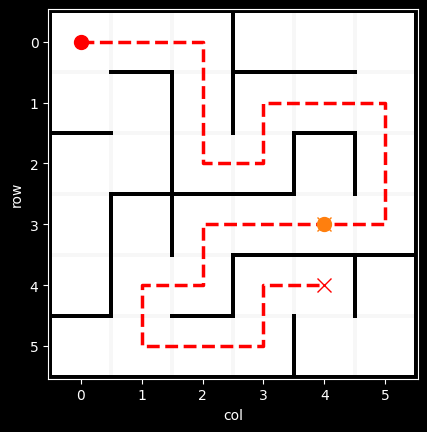

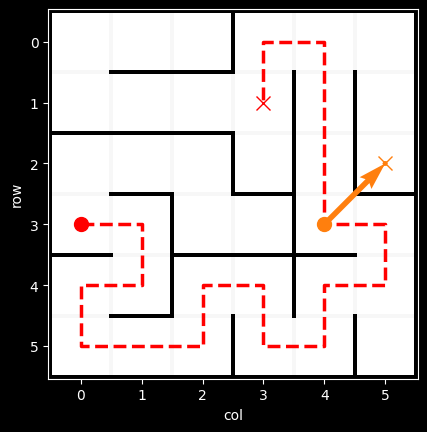

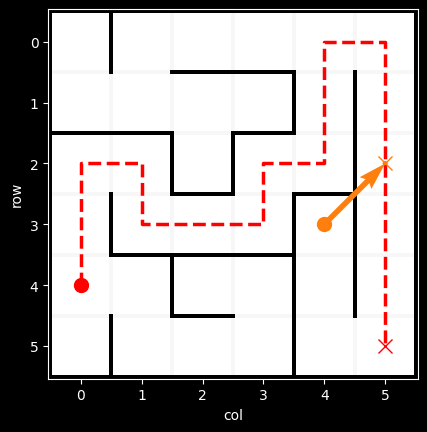

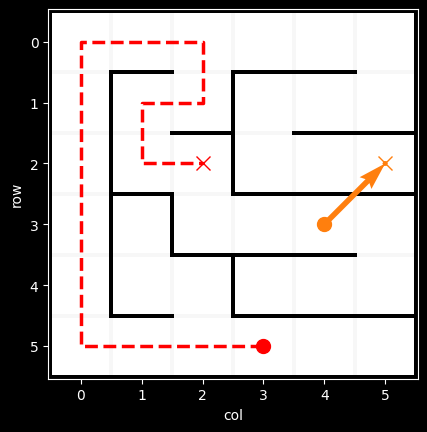

In [4]:
testdata_plot_predicted_path(MODEL, DATASET_TEST, n_mazes=5, max_new_tokens=10)

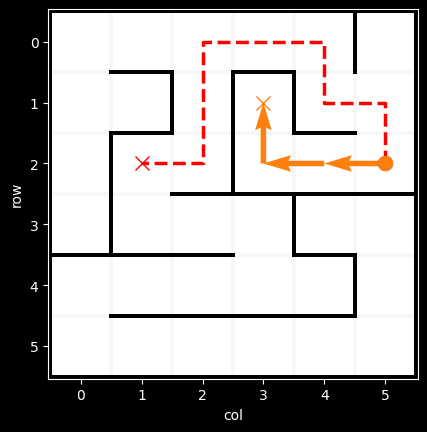

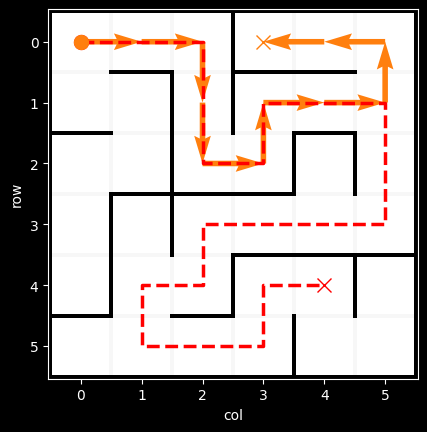

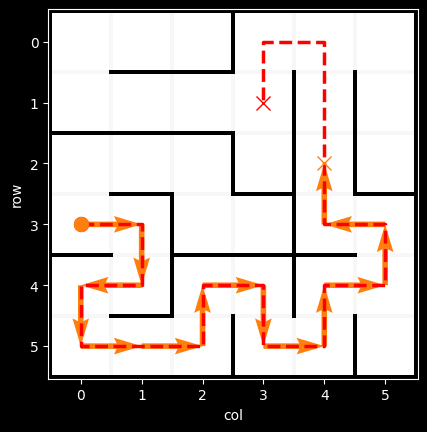

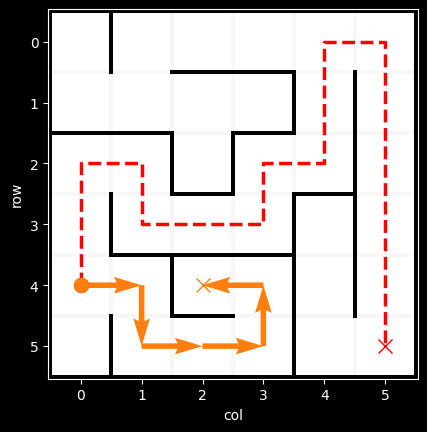

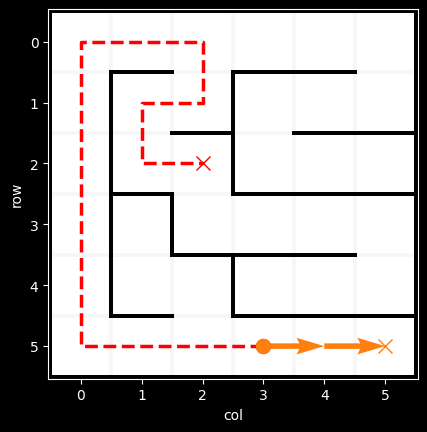

In [5]:
# now let's do the same with the baseline solver
BASELINE_SOLVER: RandomBaseline = RandomBaseline(MODEL.zanj_model_config)
testdata_plot_predicted_path(BASELINE_SOLVER, DATASET_TEST, n_mazes=5, max_new_tokens=15)

# run path dist eval

In [6]:
def eval_model_at_checkpoints(
	model_path: Path,
	dataset: MazeDataset,
	max_checkpoints: int = 50,
) -> dict[str, dict[int, StatCounter]]:
	"""runs evaluate_model on various checkpoints of a model
	
	returned dict maps eval name to a dict of checkpoint index to statcounter
	"""

	model_checkpoints: list[tuple[int, Path]] = get_checkpoint_paths_for_run(MODEL_PATH.parent, "zanj")
	model_checkpoints.sort(key=lambda x: x[0])
	print(f"Found {len(model_checkpoints)} checkpoints, min_index={model_checkpoints[0][0]}, max_index={model_checkpoints[-1][0]}")

	# filter to every nth checkpoint
	num_checkpoints: int = len(model_checkpoints)
	take_every_nth: int = max(1, num_checkpoints // max_checkpoints)
	model_checkpoints: list[tuple[int, Path]] = model_checkpoints[::take_every_nth]
	print(f"will evaluate {len(model_checkpoints)} checkpoints: {[(i,p.as_posix()) for i,p in model_checkpoints]}")

	pathdist_scores_idx: dict[int, dict[str, StatCounter]] = dict()

	for idx, checkpoint_path in model_checkpoints:
		print(f"# Evaluating checkpoint {idx} at {checkpoint_path}")
		model_at_index = ZanjHookedTransformer.read(checkpoint_path)
		pathdist_scores_idx[idx] = evaluate_model(
			model=model_at_index,
			dataset=dataset,
		)


	return {
		name: {
			idx: scores[name]
			for idx, scores in pathdist_scores_idx.items()
		}
		for name in pathdist_scores_idx[list(pathdist_scores_idx.keys())[0]].keys()
	}

In [7]:
def plot_pathdist_scores(
		data: dict[str, dict[int, StatCounter]],
		colors: dict[str, str]|None = None,
		percentile_bounds: tuple[float, float] = (0.4, 0.6),
	):
	"""plots pathdist scores over checkpoints
	
	expects a dict mapping eval name to a dict of checkpoint index to statcounter
	"""

	if colors is None:
		colors = {
			func_name: f"C{i}"
			for i, func_name in enumerate(data.keys())
		}

	fig, ax = plt.subplots(len(data), 1, figsize = (8, 4 * len(data)))
	fig.subplots_adjust(hspace = 0.5)
		
	for i, (name, scores_indexed) in enumerate(data.items()):
		x = list(scores_indexed.keys())
		y = [
			scores_indexed[i].median()
			for i in x
		]
		ax[i].plot(x, y, label=name, color=colors[name])
		# plot shaded error bars
		y_ub = [
			scores_indexed[i].percentile(percentile_bounds[1])
			for i in x
		]
		y_lb = [
			scores_indexed[i].percentile(percentile_bounds[0])
			for i in x
		]
		ax[i].fill_between(
			x, y_lb, y_ub,
	    	alpha=0.5, 
			edgecolor=colors[name], facecolor=colors[name],
		)

		ax[i].set_title(f"{name}, {percentile_bounds = }")
		ax[i].set_xlabel("Checkpoint")
		ax[i].set_ylabel("score")

	plt.show()

In [8]:
PATHDIST_SCORES: dict[str, dict[int, StatCounter]] = eval_model_at_checkpoints(MODEL_PATH, DATASET_TEST, max_checkpoints=5)

Found 2 checkpoints, min_index=0, max_index=78
will evaluate 2 checkpoints: [(0, '../examples/multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/checkpoints/model.iter_0.zanj'), (78, '../examples/multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/checkpoints/model.iter_78.zanj')]
# Evaluating checkpoint 0 at ..\examples\multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02\checkpoints\model.iter_0.zanj
# Evaluating checkpoint 78 at ..\examples\multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02\checkpoints\model.iter_78.zanj


F:\KNC\maze-transformer\maze_transformer\evaluation\path_evals.py:78: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([], dtype=float64)

F:\KNC\maze-transformer\maze_transformer\evaluation\path_evals.py:78: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([[0, 3]])



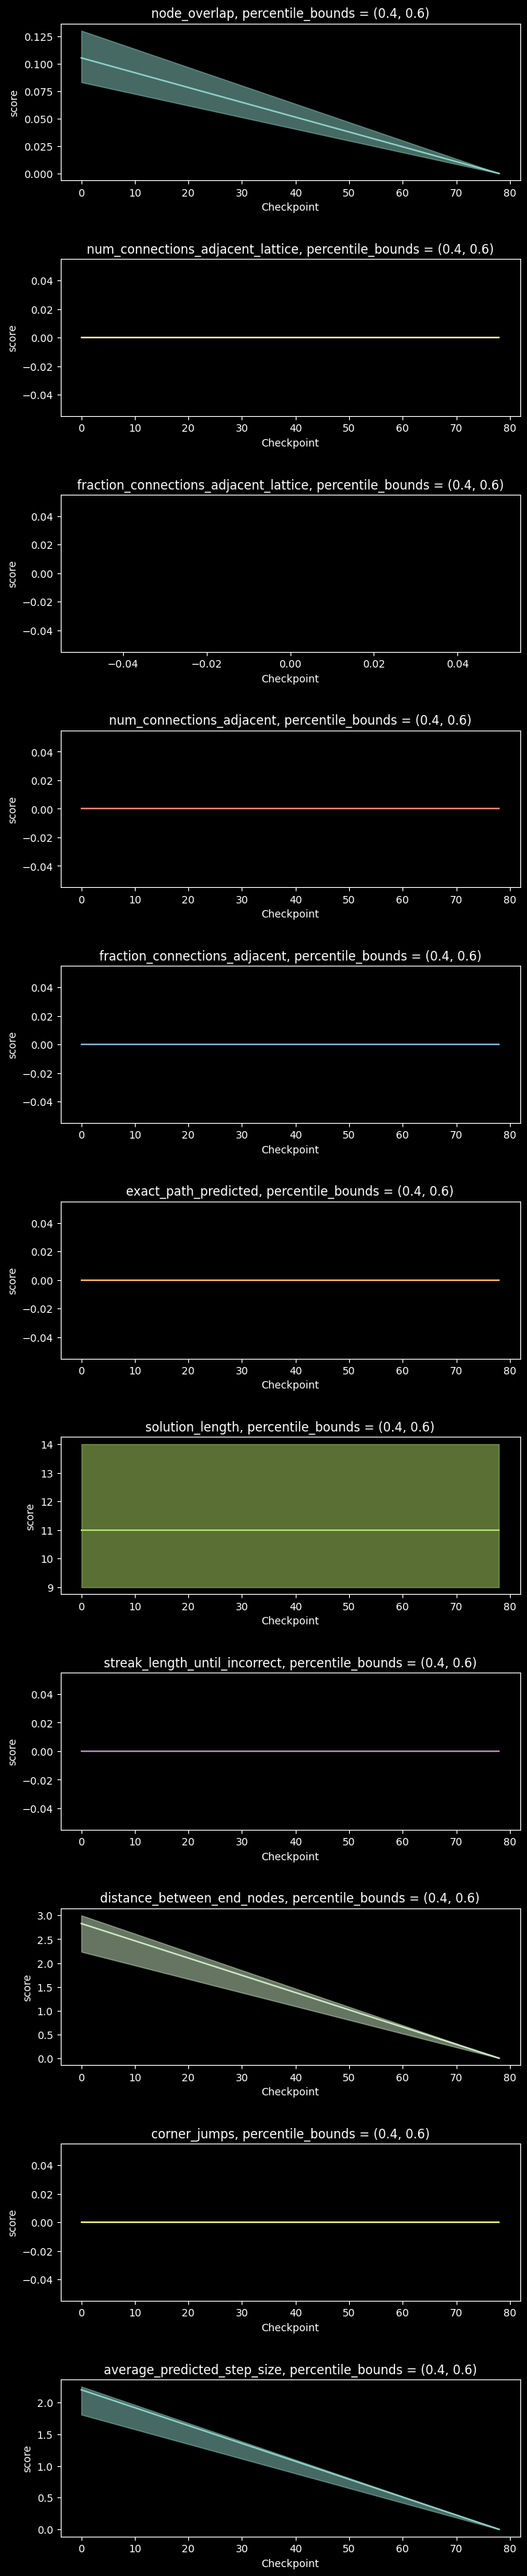

In [9]:
plot_pathdist_scores(PATHDIST_SCORES)